In [1]:
# importando as bibliotecas necessárias para rodar o script

# manipulação de números de ponto flutuante
import numpy as np

# plotagem de gráficos
import matplotlib.pyplot as plt

# criação manipulação de data frames
import pandas as pd

# funções matemáticas
import math

# criação dos modelos de DL
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# preprocessador - escalar os dados
from sklearn.preprocessing import MinMaxScaler

# metrica de desempenho (MSE)
from sklearn.metrics import mean_squared_error

In [2]:
events_dict = {
    'BLUE: first_blood': 0,
    'BLUE: dragon': 1,
    'BLUE: herald': 2,
    'BLUE: first_tower_top': 3,
    'BLUE: first_tower_mid': 4,
    'BLUE: first_tower_bot': 5,
    'BLUE: second_tower_top': 6,
    'BLUE: second_tower_mid': 7,
    'BLUE: second_tower_bot': 8,
    'BLUE: third_tower_top': 9,
    'BLUE: third_tower_mid': 10,
    'BLUE: third_tower_bot': 11,
    'BLUE: inhibitor_top': 12,
    'BLUE: inhibitor_mid': 13,
    'BLUE: inhibitor_bot': 14,
    'BLUE: baron': 15,
    'BLUE: elder_dragon': 16,
    'BLUE: nexus_tower': 17,
    'BLUE: nexus': 18,
    'RED: first_blood': 19,
    'RED: dragon': 20,
    'RED: herald': 21,
    'RED: first_tower_top': 22,
    'RED: first_tower_mid': 23,
    'RED: first_tower_bot': 24,
    'RED: second_tower_top': 25,
    'RED: second_tower_mid': 26,
    'RED: second_tower_bot': 27,
    'RED: third_tower_top': 28,
    'RED: third_tower_mid': 29,
    'RED: third_tower_bot': 30,
    'RED: inhibitor_top': 31,
    'RED: inhibitor_mid': 32,
    'RED: inhibitor_bot': 33,
    'RED: baron': 34,
    'RED: elder_dragon': 35,
    'RED: nexus_tower': 36,
    'RED: nexus': 37
}

df = pd.read_csv('data/clean-one-line.csv')
df = df.drop('game', axis=1)
data = df.values.tolist()

for game in data:
    for i, s in enumerate(game):
        if s in events_dict:
            game[i] = events_dict.get(s)
        else:
            del game[i]

for game in data:
    game = [item for item in game if not(math.isnan(item)) == True]

data = [[x for x in y if not np.isnan(x)] for y in data]

dataArray = []

for game in data:
    dataArray += game

In [3]:
df = pd.read_csv('data/clean-one-line.csv')
df = df.drop('game', axis=1)
data = df.values.tolist()

for game in data:
    for i, s in enumerate(game):
        if s in events_dict:
            game[i] = events_dict.get(s)
        else:
            del game[i]

for game in data:
    game = [item for item in game if not(math.isnan(item)) == True]

data = [[x for x in y if not np.isnan(x)] for y in data]
dataArray = []

for game in data:
    dataArray += game

dataframe = pd.DataFrame(dataArray)
dataset = dataframe.values
dataset = dataset.astype('float32')

# vislumbrar um pedaço dos dados e formato lido
print("\n* Dimensão dos dados:", dataset.shape) 
# 36 amostras/instâncias, univariadas (um único valor real)
print("* Dados originais:")
print(dataset[:10])


* Dimensão dos dados: (6128, 1)
* Dados originais:
[[19.]
 [ 2.]
 [ 3.]
 [20.]
 [21.]
 [ 4.]
 [ 5.]
 [20.]
 [23.]
 [34.]]


In [4]:
# funcao auxiliar para criar os itervalos de previsao
# é a mesma que usamos no exemplo anterior
def create_dataset(dataset, janela_previsao=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-janela_previsao-1):
        a = dataset[i:(i+janela_previsao), 0]
        dataX.append(a)
        dataY.append(dataset[i + janela_previsao, 0])
    return np.array(dataX), np.array(dataY)

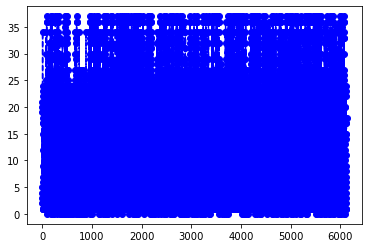

In [5]:
# plotar os dados para visualizar a nossa time series
plt.plot(dataset, linestyle='--', marker='o', color='b')

In [6]:
# Normalizando os dados

# escalar os dados no intervalo [-1,1] usando sklearn
# from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)

print("* Dados escalados:")
print(dataset[:10].transpose())

* Dados escalados:
[[ 0.02702701 -0.8918919  -0.8378378   0.08108115  0.13513517 -0.7837838
  -0.7297297   0.08108115  0.24324322  0.83783793]]


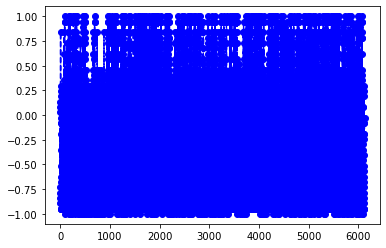

In [7]:
# visualizar nossos dados escalados
# Obs: prestar atenção ao eixo Y, agora varia entre [-1,+1]
plt.plot(dataset, linestyle='--', marker='o', color='b')

In [8]:
# Ajustando conjunto de treino e teste
# 80% dos exemplos no treino, 20% no teste
train_size = int(len(dataset) * 0.80)
test_size  = len(dataset) - train_size

#print(train_size, test_size)
print("- Numero de instâncias treino: ", train_size)
print("- Numero de instâncias teste: ", test_size)

- Numero de instâncias treino:  4902
- Numero de instâncias teste:  1226


In [9]:
# Conjunto de treinamento - amostras de 0-29
# Conjunto de teste - amostras de 30-35
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print("* Conjunto de Treinamento:", train.shape)
#print(train)

print("* Conjunto de Teste:", test.shape)
#print(test)

* Conjunto de Treinamento: (4902, 1)
* Conjunto de Teste: (1226, 1)


In [10]:
# reshape em X=t and Y=t+1
# isto é, criando dados no padrão DF = [X|Y]
# para cada X, o Y = X+1

janela_previsao = 1
trainX, trainY = create_dataset(train, janela_previsao)

In [11]:
# reshape em X=t and Y=t+1 para o conjunto de teste

testX, testY  = create_dataset(test, janela_previsao)

In [12]:
# Ajustando os conjunto de treino (trainX) e teste (testX) para o formato
# [samples, time_steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
# Criando nossa rede recorrente com unidades de LSTM 
# formato keras sequencial
model = Sequential()
model.add(LSTM(units=4, input_shape=(1, janela_previsao))) 
model.add(Dense(1))

# visualizar o modelo (arquitetura) que geramos
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [14]:
# parâmetros para otimizacao
# medida a ser minimizada = Erro quadrático médio (Mean Squared Error)
# Otimizador, algoritmo de treinamento = Adam
# métricas para avaliar o modelo = MSE, RMSE, MAE
model.compile(loss='mean_squared_error', 
              optimizer='adam', 
              metrics=["MeanSquaredError", "RootMeanSquaredError", "MeanAbsoluteError"]
)

In [15]:
# Treinando nossa rede
# epocas = 100
# batch_size = 1, treinar amostra por amostra
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
4900/4900 - 11s - loss: 0.3208 - mean_squared_error: 0.3208 - root_mean_squared_error: 0.5664 - mean_absolute_error: 0.4846 - 11s/epoch - 2ms/step
Epoch 2/100
4900/4900 - 8s - loss: 0.2909 - mean_squared_error: 0.2909 - root_mean_squared_error: 0.5393 - mean_absolute_error: 0.4649 - 8s/epoch - 2ms/step
Epoch 3/100
4900/4900 - 8s - loss: 0.2877 - mean_squared_error: 0.2877 - root_mean_squared_error: 0.5364 - mean_absolute_error: 0.4640 - 8s/epoch - 2ms/step
Epoch 4/100
4900/4900 - 8s - loss: 0.2867 - mean_squared_error: 0.2867 - root_mean_squared_error: 0.5354 - mean_absolute_error: 0.4641 - 8s/epoch - 2ms/step
Epoch 5/100
4900/4900 - 9s - loss: 0.2867 - mean_squared_error: 0.2867 - root_mean_squared_error: 0.5354 - mean_absolute_error: 0.4640 - 9s/epoch - 2ms/step
Epoch 6/100
4900/4900 - 8s - loss: 0.2863 - mean_squared_error: 0.2863 - root_mean_squared_error: 0.5350 - mean_absolute_error: 0.4636 - 8s/epoch - 2ms/step
Epoch 7/100
4900/4900 - 8s - loss: 0.2859 - mean_squared

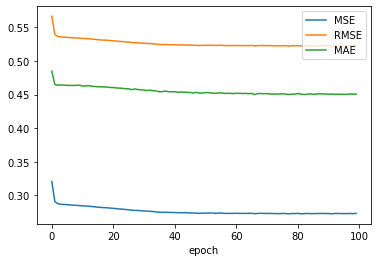

In [16]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.xlabel('epoch')
plt.legend(['MSE', 'RMSE', 'MAE'], loc='upper right')
plt.show()

In [17]:
# Realizando as predições nos conjuntos de treino/teste

# predição no conjunto de trienamento
trainPredict = model.predict(trainX)

# predição no conjunto de teste
testPredict  = model.predict(testX)

39/39 [==============================] - 0s 1ms/step


In [18]:
# Aplicando a inversa da escala para retornar ao valor original
# training set
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

# testing set
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [19]:
# Calculando RMSE no treino e teste
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Teste Score: %.2f RMSE' % (testScore))

Treino: 9.65 RMSE
Teste Score: 9.93 RMSE


In [20]:
# Ajustando o plot do treino
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[janela_previsao:len(trainPredict)+janela_previsao, :] = trainPredict

In [21]:
# Ajustando o plot do teste
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(janela_previsao*2)+1:len(dataset)-1, :] = testPredict

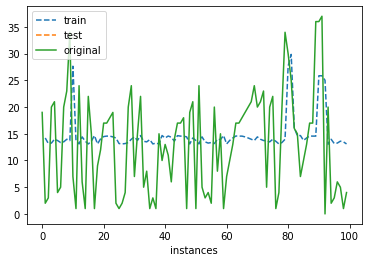

In [22]:
# Ajustando o plot com o sinal original
# - verde   = dataset original
# - azul    = predicoes geradas no conjunto de treinamento
# - laranja = predicoes geradas no conjunto de teste

plt.plot(trainPredictPlot[:100], linestyle="--")
plt.plot(testPredictPlot[:100], linestyle="--")
plt.plot(scaler.inverse_transform(dataset)[:100])
plt.xlabel('instances')
plt.legend(['train', 'test', 'original'], loc='upper left')
plt.show()